In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from analysis_util import *
from sklearn.model_selection import train_test_split
from sklearn import metrics
from matplotlib.ticker import MaxNLocator
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from torch_util import *

import pickle
import seaborn as sns
'''this script test the hypothesis whether people respond to a fixed bound
pepole  '''
# global setting f
plt.rcParams.update({"font.size": 18})
colors = sns.color_palette("deep")
sns.set(style="whitegrid")
# top level dir 
# 






In [2]:

PROJECT_DIR = "/data/rwchain-all/round2"
BEH_DIR = os.path.join(PROJECT_DIR, "rwchain-beh/data")
EEG_DIR = os.path.join(PROJECT_DIR, "rwchain-eeg")
ALL_BEH_DIR = os.path.join(PROJECT_DIR, 'rwchain-beh', 'combined')


In [3]:
CODE_DIR = "/home/jenny/evidence-chain/"
FIG_DIR = os.path.join(CODE_DIR, "figs/cnn_kernel_check_multiple/")
SAVE_DIR = os.path.join(CODE_DIR, "simple_cnn_models_multiple/")

In [4]:

# Check if the directory exists
if not os.path.exists(FIG_DIR):
    # Create the directory
    os.makedirs(FIG_DIR)
    print(f"Directory '{FIG_DIR}' was created.")
else:
    print(f"Directory '{FIG_DIR}' already exists.")



if not os.path.exists(SAVE_DIR):
    # Create the directory
    os.makedirs(SAVE_DIR)
    print(f"Directory '{SAVE_DIR}' was created.")
else:
    print(f"Directory '{SAVE_DIR}' already exists.")

Directory '/home/jenny/evidence-chain/figs/cnn_kernel_check_multiple/' already exists.
Directory '/home/jenny/evidence-chain/simple_cnn_models_multiple/' already exists.


In [5]:
stimdur = '250'
pos = 8
evaluate_mode = False

In [6]:

list_of_subj = os.listdir(BEH_DIR)
list_of_subj.sort()
# list_of_subj = [list_of_subj[5]]

df = pd.read_pickle(os.path.join(ALL_BEH_DIR, 'all_df_concat.pkl'))
# organize some columsn
 
df['key'][df['key'] == '[5]'] = 1
df['key'][df['key'] == '[3]'] = 1
df['key'][df['key'] == '[2]'] = 0
df['cumsum'] = df['sequence_clean'].apply(lambda x: [sum(x[:i+1]) for i in range(len(x))])

# get rid of a ;pw acc subject
df = df[df['sid']!='s108']

if stimdur == '100':
    df = df[df['stimDur'] == 0.1]
if stimdur == '250':
    df = df[df['stimDur'] == 0.25]
# df = df[df['stimDur'] != 0.5]
# df = df[df['stimDur'] != 0.05]
# df = df[df['stimDur'] == 0.1]



/tmp/ipykernel_116479/100844696.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['key'][df['key'] == '[5]'] = 1
/tmp/ipykernel_116479/100844696.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['key'][df['key'] == '[3]'] = 1
/tmp/ipykernel_116479/100844696.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['key'][df['key'] == '[2]'] = 0


In [7]:
# correct the count
df = correct_samples_by_condition(df)

cumsum = np.array(df['cumsum'].to_list())
sequence =  np.array(df['sequence_clean'].to_list())
count = df['count_corrected'].to_numpy()

In [8]:
df.shape

(3400, 13)

In [9]:
df.head()


,time,bytetime,press,count,key,stimDur,Bias,sequence,block,sequence_clean,sid,cumsum,count_corrected
0,2.6166679859161377,2611,[1],10,0,0.25,0.12,[-1. 1. -1. 1. -1. 1. -1. -1. -1. -1. -1. ...,0,"[-1.0, 1.0, -1.0, 1.0, -1.0, 1.0, -1.0, -1.0, ...",s102,"[-1.0, 0.0, -1.0, 0.0, -1.0, 0.0, -1.0, -2.0, ...",9
1,2.2499890327453613,2233,[1],8,1,0.25,0.12,[-1. -1. -1. 1. 1. 1. 1. 1. -1. -1. -1. -...,0,"[-1.0, -1.0, -1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1...",s102,"[-1.0, -2.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, ...",7
2,2.1333320140838623,2118,[1],8,0,0.25,0.12,[ 1. -1. -1. -1. 1. 1. -1. -1. -1. -1. 1. ...,0,"[1.0, -1.0, -1.0, -1.0, 1.0, 1.0, -1.0, -1.0, ...",s102,"[1.0, 0.0, -1.0, -2.0, -1.0, 0.0, -1.0, -2.0, ...",7
3,1.2833738327026367,1270,[1],5,1,0.25,0.12,[ 1. 1. 1. 1. -1. 1. 1. -1. -1. -1. 1. -...,0,"[1.0, 1.0, 1.0, 1.0, -1.0, 1.0, 1.0, -1.0, -1....",s102,"[1.0, 2.0, 3.0, 4.0, 3.0, 4.0, 5.0, 4.0, 3.0, ...",4
4,2.3333139419555664,2318,[1],9,1,0.25,0.12,[-1. 1. -1. 1. 1. -1. 1. 1. 1. -1. -1. -...,0,"[-1.0, 1.0, -1.0, 1.0, 1.0, -1.0, 1.0, 1.0, 1....",s102,"[-1.0, 0.0, -1.0, 0.0, 1.0, 0.0, 1.0, 2.0, 3.0...",8


In [10]:
count.max()

29

In [11]:
# create a matrix of +1 and -1 with NaNs if the chain terminates

chain_matrix = get_chain_matrix(sequence, count)


In [12]:
# fig, ax = plot_performance_matrix(performance_matrix_test)

In [13]:
dataset, dataset_resp = make_dataset(pos, count, chain_matrix)
x_train_val, x_test, y_train_val, y_test = train_test_split(
    dataset, dataset_resp, test_size=0.3, random_state=2024
)
x_train, x_val, y_train, y_val = train_test_split(
x_train_val, y_train_val, test_size=0.25, random_state=1
)

In [14]:
# x_train = get_evidence(x_train)
# x_val = get_evidence(x_val)
# x_test = get_evidence(x_test)

In [15]:


# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create datasets
train_dataset = create_dataset(x_train, y_train)
val_dataset = create_dataset(x_val, y_val)
test_dataset = create_dataset(x_test, y_test)
train_val_dataset = create_dataset(x_train_val, y_train_val)

# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
train_val_loader= DataLoader(train_val_dataset, batch_size=batch_size)



x_train.shape

In [16]:

# Define the model
class CNN1D(nn.Module):
    def __init__(self):
        super(CNN1D, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=4, stride=1, padding=0)  # output is N x 16 x 5
        self.fc1 = nn.Linear(16, 1,bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        # x = torch.relu(x)
        x, max_ind= torch.max(x[:,:,-2:], 2)  # Global average pooling
        # print(max_ind)
        x = self.fc1(x)
        x = self.sigmoid(x)
        return x

In [17]:

if evaluate_mode:
    PATH = f'/home/jenny/evidence-chain/simple_cnn_models_dual/best_pos{pos}_running,pkl'
    model =CNN1D()
    model.load_state_dict(torch.load(PATH))
    model.eval()
    model = model.to(device)


    # Loss function and optimizer
    criterion = nn.BCELoss()


    # Train the model
    num_epochs = 20
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        train_loss,_,_ = evaluate(model, train_loader, criterion,device)
        val_loss, _, _ = evaluate(model, val_loader, criterion, device)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        # if epoch % 10 ==0:
        #     print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Validation Loss: {val_loss}')

    # Evaluate AUC on the test set
    test_loss, test_outputs, test_targets = evaluate(model, test_loader, criterion, device)
    train_loss, train_outputs, train_targets = evaluate(model, train_loader, criterion, device)

    test_auc = roc_auc_score(test_targets, test_outputs)
    train_auc = roc_auc_score(train_targets, train_outputs)


    print(f'Train Loss: {train_loss}')
    print(f'Train AUC: {train_auc}')



    test_auc = roc_auc_score(test_targets, test_outputs)
    print(f'Test Loss: {test_loss}')
    print(f'Test AUC: {test_auc}')



===================ATTEMP 0======================
Train Loss: 0.3687295459565662
Train AUC: 0.7168611499668704
Test Loss: 0.3033396406815602
Test AUC: 0.6313226744186048
saved a better model!


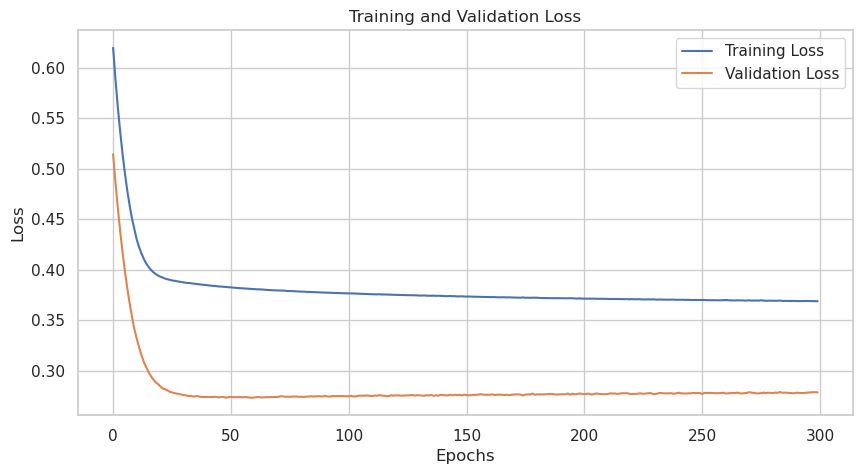

Epoch 1, Train Loss: 0.3437660665347658
Epoch 11, Train Loss: 0.34182909336583367
Epoch 21, Train Loss: 0.3411699703027462
Epoch 31, Train Loss: 0.34074957977081166
Epoch 41, Train Loss: 0.340449166195146
Epoch 51, Train Loss: 0.34021608017641924
Epoch 61, Train Loss: 0.34001158229235945
Epoch 71, Train Loss: 0.33982612295397396
Epoch 81, Train Loss: 0.3396536322503254
Epoch 91, Train Loss: 0.33949002880474616
Epoch 101, Train Loss: 0.33933872806614845
Epoch 111, Train Loss: 0.3391932552230769
Epoch 121, Train Loss: 0.33905375774564417
Epoch 131, Train Loss: 0.3389215972916833
Epoch 141, Train Loss: 0.33879271149635315
Epoch 151, Train Loss: 0.3386644032494775
Epoch 161, Train Loss: 0.33854580747670143
Epoch 171, Train Loss: 0.33842373716420143
Epoch 181, Train Loss: 0.33830341696739197
Epoch 191, Train Loss: 0.3381875064866296
Epoch 201, Train Loss: 0.338062029974214
Epoch 211, Train Loss: 0.3379371104569271
Epoch 221, Train Loss: 0.3378180645663163
Epoch 231, Train Loss: 0.3376965075

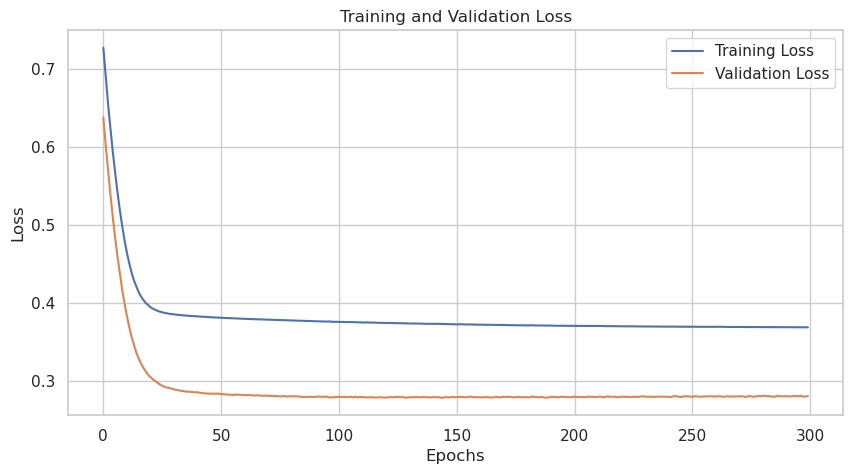

Epoch 1, Train Loss: 0.34392599299036225
Epoch 11, Train Loss: 0.3422757325501278
Epoch 21, Train Loss: 0.34176507849117804
Epoch 31, Train Loss: 0.3413829541411893
Epoch 41, Train Loss: 0.3410783204539069
Epoch 51, Train Loss: 0.34082798916718055
Epoch 61, Train Loss: 0.34061089158058167
Epoch 71, Train Loss: 0.3404205996414711
Epoch 81, Train Loss: 0.3402463048696518
Epoch 91, Train Loss: 0.3400941223933779
Epoch 101, Train Loss: 0.33995167705519447
Epoch 111, Train Loss: 0.33983075259060697
Epoch 121, Train Loss: 0.3397151781567212
Epoch 131, Train Loss: 0.33960762825505486
Epoch 141, Train Loss: 0.33950297945532304
Epoch 151, Train Loss: 0.33940603095909644
Epoch 161, Train Loss: 0.33930823720734693
Epoch 171, Train Loss: 0.33921534850679597
Epoch 181, Train Loss: 0.3391266794040285
Epoch 191, Train Loss: 0.3390389567819135
Epoch 201, Train Loss: 0.33895503909423436
Epoch 211, Train Loss: 0.33887011121059285
Epoch 221, Train Loss: 0.3387885684597081
Epoch 231, Train Loss: 0.3387065

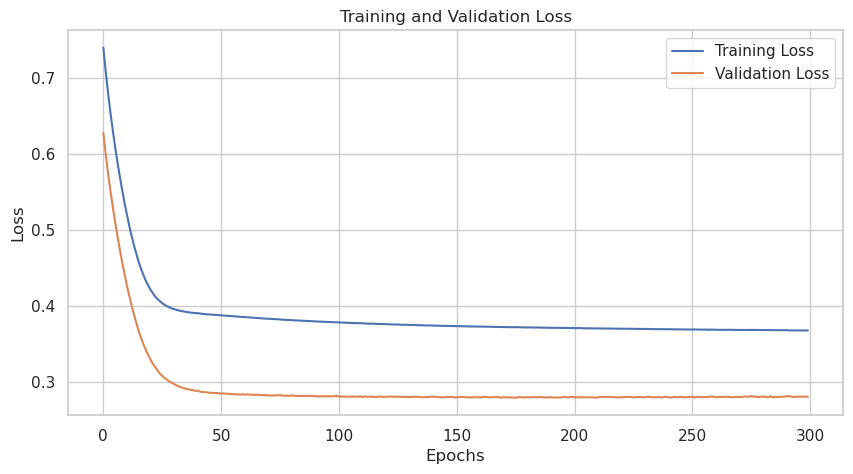

Epoch 1, Train Loss: 0.3432324143319294
Epoch 11, Train Loss: 0.3413596636262433
Epoch 21, Train Loss: 0.34065868114602976
Epoch 31, Train Loss: 0.3401549746250284
Epoch 41, Train Loss: 0.33977318734958256
Epoch 51, Train Loss: 0.33947023646584873
Epoch 61, Train Loss: 0.3392173416655639
Epoch 71, Train Loss: 0.3390102304261306
Epoch 81, Train Loss: 0.3388301360196081
Epoch 91, Train Loss: 0.33867164315848514
Epoch 101, Train Loss: 0.33853145868613804
Epoch 111, Train Loss: 0.33839286761037235
Epoch 121, Train Loss: 0.33826998184467183
Epoch 131, Train Loss: 0.338145282761804
Epoch 141, Train Loss: 0.33803089168565026
Epoch 151, Train Loss: 0.33792616118644847
Epoch 161, Train Loss: 0.3378215108452172
Epoch 171, Train Loss: 0.33772529918572
Epoch 181, Train Loss: 0.33762861274439715
Epoch 191, Train Loss: 0.3375377619060977
Epoch 201, Train Loss: 0.33744863343649895
Epoch 211, Train Loss: 0.33735931279330417
Epoch 221, Train Loss: 0.3372731075204652
Epoch 231, Train Loss: 0.33718433359

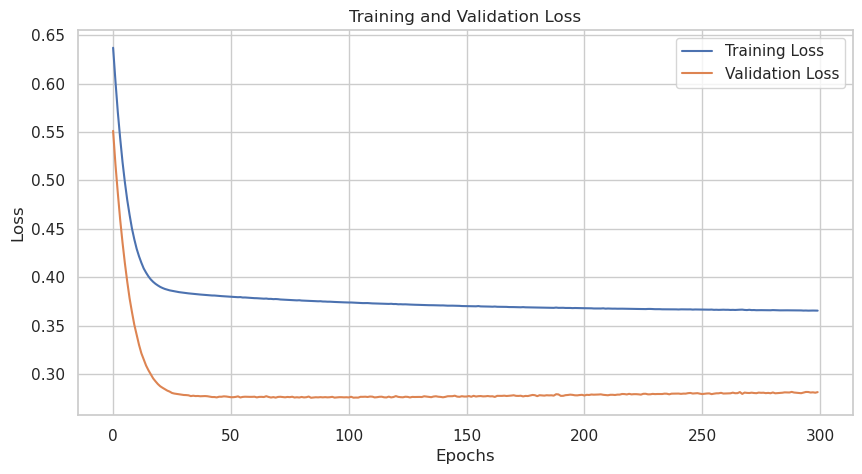

Epoch 1, Train Loss: 0.3419549398381135
Epoch 11, Train Loss: 0.34017778265065163
Epoch 21, Train Loss: 0.3396454432914997
Epoch 31, Train Loss: 0.33928538499207334
Epoch 41, Train Loss: 0.33901545610921135
Epoch 51, Train Loss: 0.3388013680433405
Epoch 61, Train Loss: 0.3386207736771682
Epoch 71, Train Loss: 0.3384577534322081
Epoch 81, Train Loss: 0.33831032545402134
Epoch 91, Train Loss: 0.3381718006627313
Epoch 101, Train Loss: 0.3380455246259426
Epoch 111, Train Loss: 0.3379286841071885
Epoch 121, Train Loss: 0.33781711397499875
Epoch 131, Train Loss: 0.3377113439913454
Epoch 141, Train Loss: 0.3376082608412052
Epoch 151, Train Loss: 0.33750998357246664
Epoch 161, Train Loss: 0.3374140550350321
Epoch 171, Train Loss: 0.3373206987463195
Epoch 181, Train Loss: 0.33723206766720476
Epoch 191, Train Loss: 0.3371473196251639
Epoch 201, Train Loss: 0.33706535655876685
Epoch 211, Train Loss: 0.3369856795360302
Epoch 221, Train Loss: 0.3369054938184804
Epoch 231, Train Loss: 0.336834228244

In [18]:
num_attempts = 300

if not evaluate_mode:
    best_test_auc = 0
    best_train_auc = 0
    num_epochs = 300
    num_epochs_final = 400
    
    for i in range(num_attempts):
        
        model_1 = CNN1D().to(device)
        # Loss function and optimizer
        criterion = nn.BCELoss()
        optimizer = Adam(model_1.parameters(), lr=0.0005)


        # Train the model
        train_losses = []
        val_losses = []

        for epoch in range(num_epochs):
            train_loss = train_epoch(model_1, train_loader, criterion, optimizer, device)
            val_loss, _, _ = evaluate(model_1, val_loader, criterion, device)
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            # if epoch % 10 ==0:
            #     print(f'Epoch {epoch+1}, Train Loss: {}, Validation Loss: {val_loss}')



        # Evaluate AUC on the test set
        test_loss, test_outputs, test_targets = evaluate(model_1, test_loader, criterion, device)
        train_loss, train_outputs, train_targets = evaluate(model_1, train_loader, criterion, device)

        test_auc = roc_auc_score(test_targets, test_outputs)
        train_auc = roc_auc_score(train_targets, train_outputs)

        print(f"===================ATTEMP {i}======================")

        print(f'Train Loss: {train_loss}')
        print(f'Train AUC: {train_auc}')



        test_auc = roc_auc_score(test_targets, test_outputs)
        print(f'Test Loss: {test_loss}')
        print(f'Test AUC: {test_auc}')

        if test_auc >best_test_auc and train_auc>best_train_auc:
            best_test_auc = test_auc
            best_train_auc = train_auc
            PATH = f'{SAVE_DIR}best_pos{pos}_running.pkl'
            torch.save(model_1.state_dict(), PATH)
            print("saved a better model!")

                # # Plot training and validation losses
            plt.figure(figsize=(10, 5))
            plt.plot(train_losses, label='Training Loss')
            plt.plot(val_losses, label='Validation Loss')
            plt.title('Training and Validation Loss')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()

            plt.show()


            conv_bias = model_1.conv1.bias.data
            weights = model_1.conv1.weight.data
            fc_weights = model_1.fc1.weight.data

            kernel = weights.cpu().numpy()
            fc_bias = fc_weights.cpu().numpy()
            conv_bias = conv_bias.cpu().numpy()
            mydict = {}
            mykeys = ["kernel", "position","fc_bias", "conv_bias"]
            values = [kernel, pos, fc_bias, conv_bias]
            for key, value in zip(mykeys, values):
                   mydict[key] = value
            
            FILEPATH  = os.path.join(SAVE_DIR, f"pos{pos}_param_running.pkl")
            with open(FILEPATH, 'wb') as pickle_file:
                pickle.dump(mydict, pickle_file)

            ## continue training)
    
            train_val_losses = []

            for epoch in range(num_epochs_final):
                train_val_loss = train_epoch(model_1, train_val_loader, criterion, optimizer, device)
                train_val_losses.append(train_val_loss)
                if epoch % 10 ==0:
                    print(f'Epoch {epoch+1}, Train Loss: {train_val_loss}')



            # Evaluate AUC on the test set
            test_loss_final, test_outputs_final, test_targets_final = evaluate(model_1, test_loader, criterion, device)
            train_loss_final, train_outputs_final, train_targets_final = evaluate(model_1, train_val_loader, criterion,device)

            test_auc_final = roc_auc_score(test_targets_final, test_outputs_final)
            train_auc_final = roc_auc_score(train_targets_final, train_outputs_final)

            print(f"===================ATTEMP {i} final training======================")

            print(f'Train Loss: {train_loss_final}')
            print(f'Train AUC: {train_auc_final}')

            print(f'Test Loss: {test_loss_final}')
            print(f'Test AUC: {test_auc_final}')


            if test_auc_final >best_test_auc and train_auc_final>best_train_auc:
                best_test_auc = test_auc_final
                best_train_auc = train_auc_final
                PATH = f'{SAVE_DIR}best_pos{pos}_continued.pkl'
                torch.save(model_1.state_dict(), PATH)
                print("saved a better final model!")

                    # # Plot training and validation losses
                plt.figure(figsize=(10, 5))
                plt.plot(train_val_losses, label='Training Loss Final')
                plt.title('Final Training Loss')
                plt.xlabel('Epochs')
                plt.ylabel('Loss')
                plt.legend()
                plt.show()

                conv_bias = model_1.conv1.bias.data
                weights = model_1.conv1.weight.data
                fc_weights = model_1.fc1.weight.data

                kernel = weights.cpu().numpy()
                fc_bias = fc_weights.cpu().numpy()
                conv_bias = conv_bias.cpu().numpy()
                mydict = {}
                mykeys = ["kernel", "position","fc_bias", "conv_bias"]
                values = [kernel, pos, fc_bias, conv_bias]
                for key, value in zip(mykeys, values):
                    # Here you can add conditions or transformations
                    mydict[key] = value
                # Save the dictionary into a pickle file
                
                FILEPATH  = os.path.join(SAVE_DIR, f"pos{pos}_param_continued.pkl")
                with open(FILEPATH, 'wb') as pickle_file:
                    pickle.dump(mydict, pickle_file)




===================ATTEMP 0 final training======================
Train Loss: 0.3370025183620124
Train AUC: 0.703754563229693
Test Loss: 0.30162919484652007
Test AUC: 0.6229651162790698
saved a better final model!


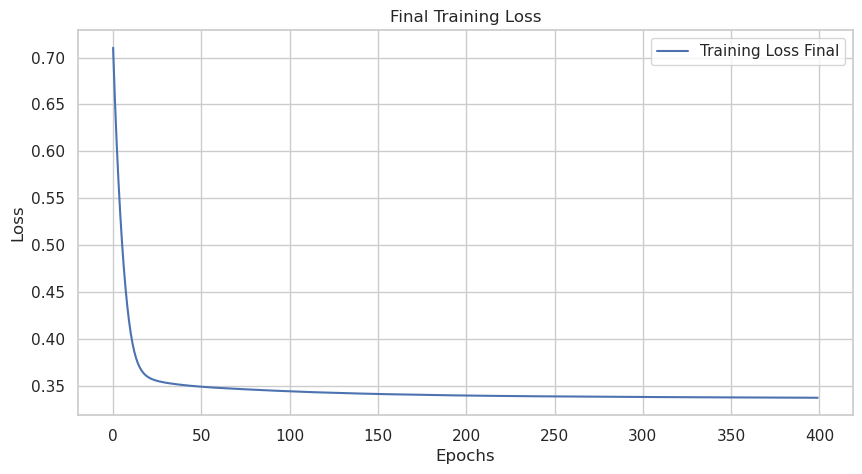

===================ATTEMP 1 final training======================
Train Loss: 0.33623743828000696
Train AUC: 0.7123893805309736
Test Loss: 0.29971324709745556
Test AUC: 0.6311046511627908
saved a better final model!


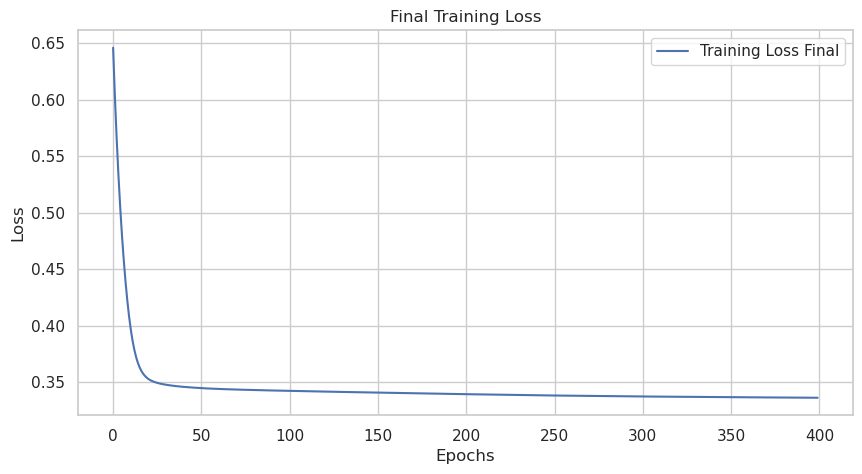

===================ATTEMP 2 final training======================
Train Loss: 0.3374873399734497
Train AUC: 0.7010194509431618
Test Loss: 0.3034497717252144
Test AUC: 0.6355377906976745
===================ATTEMP 3 final training======================
Train Loss: 0.33750717496049815
Train AUC: 0.7027825811774546
Test Loss: 0.29996631237176746
Test AUC: 0.6247819767441861
===================ATTEMP 4 final training======================
Train Loss: 0.3370499872955783
Train AUC: 0.7067722284383865
Test Loss: 0.2979094764361015
Test AUC: 0.6334302325581396
===================ATTEMP 5 final training======================
Train Loss: 0.33596602596085645
Train AUC: 0.7098237999977397
Test Loss: 0.301783236173483
Test AUC: 0.6223110465116279
===================ATTEMP 6 final training======================
Train Loss: 0.33600134685121735
Train AUC: 0.7093943195560529
Test Loss: 0.30278715376670545
Test AUC: 0.6243459302325582
===================ATTEMP 7 final training======================
Train 

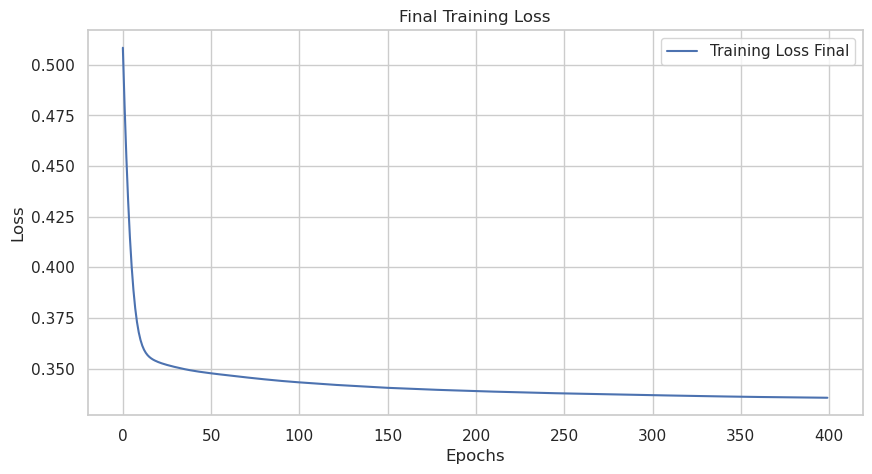

===================ATTEMP 9 final training======================
Train Loss: 0.3356958031654358
Train AUC: 0.7095977576600098
Test Loss: 0.3020570851289309
Test AUC: 0.6242005813953488
===================ATTEMP 10 final training======================
Train Loss: 0.33591481786349725
Train AUC: 0.7089535369974798
Test Loss: 0.3013013142805833
Test AUC: 0.6231104651162791
===================ATTEMP 11 final training======================
Train Loss: 0.3370453833506025
Train AUC: 0.7072017088800733
Test Loss: 0.3001068394917708
Test AUC: 0.6398982558139535
===================ATTEMP 12 final training======================
Train Loss: 0.3361549377441406
Train AUC: 0.7088631200623876
Test Loss: 0.30071258315673244
Test AUC: 0.6269622093023256
===================ATTEMP 13 final training======================
Train Loss: 0.33752147801991167
Train AUC: 0.7028164875281141
Test Loss: 0.2999599805245033
Test AUC: 0.6348837209302326
===================ATTEMP 14 final training======================
Tr

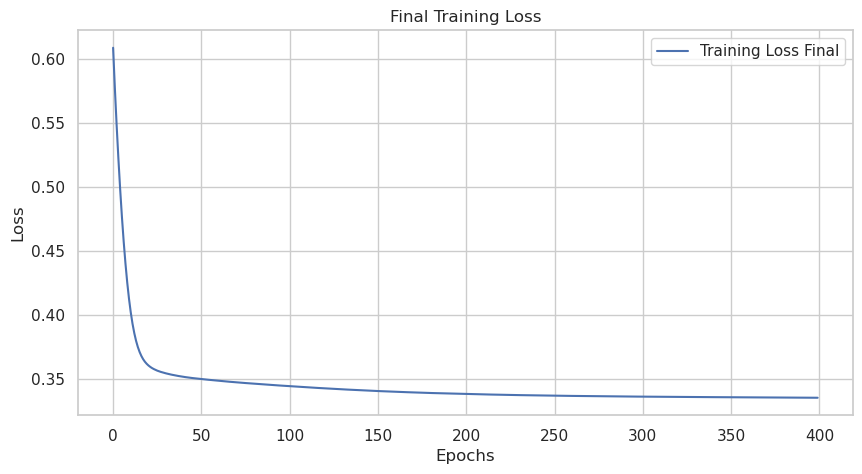

===================ATTEMP 195 final training======================
Train Loss: 0.3384307725676175
Train AUC: 0.6946111506685203
Test Loss: 0.3033513598717176
Test AUC: 0.6274709302325583
===================ATTEMP 196 final training======================
Train Loss: 0.3352947348150714
Train AUC: 0.712909277907752
Test Loss: 0.30152057340511906
Test AUC: 0.6358284883720932
===================ATTEMP 197 final training======================
Train Loss: 0.3366676152780138
Train AUC: 0.7076876999061924
Test Loss: 0.300873916882735
Test AUC: 0.6317587209302326
===================ATTEMP 198 final training======================
Train Loss: 0.33619802984698066
Train AUC: 0.7087614010104093
Test Loss: 0.300442540874848
Test AUC: 0.6262354651162791
===================ATTEMP 199 final training======================
Train Loss: 0.33477677045197324
Train AUC: 0.7145706890900666
Test Loss: 0.3000864890905527
Test AUC: 0.6287063953488373
===================ATTEMP 200 final training=====================

In [19]:
num_attempts = 300


if not evaluate_mode:
    best_test_auc = 0
    best_train_auc = 0
    num_epochs_final = 400
    
    for i in range(num_attempts):
        
        model_2 = CNN1D().to(device)
        # Loss function and optimizer
        criterion = nn.BCELoss()
        optimizer = Adam(model_2.parameters(), lr=0.0005)



        train_val_losses = []

        for epoch in range(num_epochs_final):
            train_val_loss = train_epoch(model_2, train_val_loader, criterion, optimizer,device)
            train_val_losses.append(train_val_loss)


        # Evaluate AUC on the test set
        test_loss_final, test_outputs_final, test_targets_final = evaluate(model_2, test_loader, criterion, device)
        train_loss_final, train_outputs_final, train_targets_final = evaluate(model_2, train_val_loader, criterion,device)

        test_auc_final = roc_auc_score(test_targets_final, test_outputs_final)
        train_auc_final = roc_auc_score(train_targets_final, train_outputs_final)

        print(f"===================ATTEMP {i} final training======================")

        print(f'Train Loss: {train_loss_final}')
        print(f'Train AUC: {train_auc_final}')

        print(f'Test Loss: {test_loss_final}')
        print(f'Test AUC: {test_auc_final}')


        if test_auc_final >best_test_auc and train_auc_final>best_train_auc:
            best_test_auc = test_auc_final
            best_train_auc = train_auc_final
            PATH = f'{SAVE_DIR}best_pos{pos}_final.pkl'
            torch.save(model_2.state_dict(), PATH)
            print("saved a better final model!")

                # # Plot training and validation losses
            plt.figure(figsize=(10, 5))
            plt.plot(train_val_losses, label='Training Loss Final')
            plt.title('Final Training Loss')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()
            plt.show()

            conv_bias = model_2.conv1.bias.data
            weights = model_2.conv1.weight.data
            fc_weights = model_2.fc1.weight.data

            kernel = weights.cpu().numpy()
            fc_bias = fc_weights.cpu().numpy()
            conv_bias = conv_bias.cpu().numpy()
            mydict = {}
            mykeys = ["kernel", "position","fc_bias", "conv_bias"]
            values = [kernel, pos, fc_bias, conv_bias]
            for key, value in zip(mykeys, values):
                # Here you can add conditions or transformations
                mydict[key] = value
            # Save the dictionary into a pickle file
            
            FILEPATH  = os.path.join(SAVE_DIR, f"pos{pos}_param_final.pkl")
            with open(FILEPATH, 'wb') as pickle_file:
                pickle.dump(mydict, pickle_file)


In [20]:
model_2.fc1.weight.data

tensor([[ 0.1800, -0.4606, -0.2845,  0.1849, -0.3684, -0.2912,  0.4529, -0.0786,
         -0.4843,  0.2652, -0.4661, -0.4095, -0.3450, -0.3952, -0.2940,  0.3202]],
       device='cuda:0')

In [21]:
conv_bias = model_2.conv1.bias.data

In [22]:
conv_bias

tensor([-0.4565,  0.1709, -0.3856, -0.3276,  0.3107, -0.3225, -0.3924,  0.1805,
        -0.2418, -0.6178,  0.5679,  0.3832,  0.0497, -0.2834,  0.5497, -0.1560],
       device='cuda:0')

In [23]:
weights = model_2.conv1.weight.data

In [24]:
weights

tensor([[[ 6.2014e-01,  1.3080e-01, -4.3123e-01,  1.3093e-01]],

        [[ 1.5707e-01, -5.3695e-01, -5.3677e-01,  6.4121e-01]],

        [[-5.2384e-02, -2.6452e-01, -5.7726e-01,  3.4323e-01]],

        [[ 4.2735e-01, -3.9267e-01, -2.6989e-04,  3.9240e-01]],

        [[-2.9722e-01, -1.3987e-01,  5.0228e-01,  5.0141e-01]],

        [[ 4.9629e-01,  7.2803e-01, -4.3962e-01, -4.3391e-01]],

        [[-4.7264e-01,  2.8725e-01, -9.8862e-02,  2.8723e-01]],

        [[-1.4378e-01, -1.7597e-01,  3.3461e-01,  2.8280e-01]],

        [[-1.5571e-01, -7.0868e-02,  6.9772e-01, -6.4963e-01]],

        [[ 1.6690e-01,  4.4422e-02, -1.2243e-01,  4.4474e-02]],

        [[-1.2658e-01,  3.8912e-01, -3.4843e-01, -3.4781e-01]],

        [[-3.3301e-01, -3.2050e-01, -3.2030e-01, -7.2203e-01]],

        [[ 3.9287e-01, -2.4640e-01,  5.5053e-01,  5.5057e-01]],

        [[ 8.9970e-02,  4.3529e-01, -5.5214e-01, -2.8611e-01]],

        [[ 3.3723e-01,  4.8022e-01,  4.8027e-01,  5.5142e-01]],

        [[ 4.8036e-01, -4

In [25]:
fc_weights = model_2.fc1.weight.data

In [26]:
fc_weights

tensor([[ 0.1800, -0.4606, -0.2845,  0.1849, -0.3684, -0.2912,  0.4529, -0.0786,
         -0.4843,  0.2652, -0.4661, -0.4095, -0.3450, -0.3952, -0.2940,  0.3202]],
       device='cuda:0')

In [27]:
fc_weights[0]>0


tensor([ True, False, False,  True, False, False,  True, False, False,  True,
        False, False, False, False, False,  True], device='cuda:0')

[ 0.15706791 -0.53695005 -0.53676564  0.64120793]


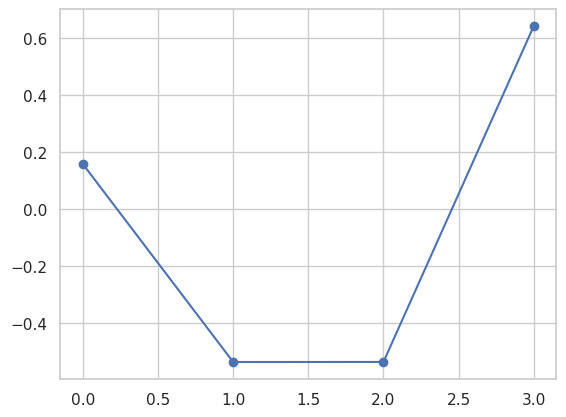

[-0.05238366 -0.26451847 -0.57725596  0.34323278]


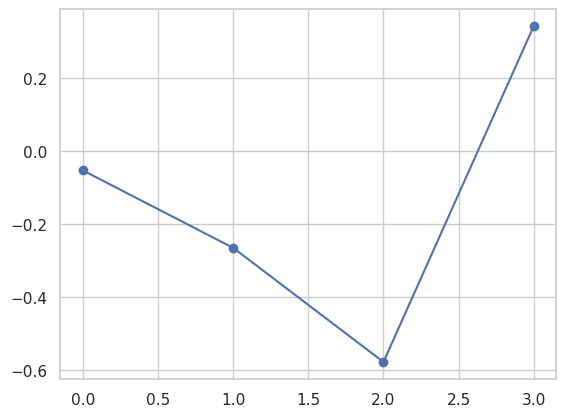

[-0.2972173  -0.13987154  0.50227743  0.50140506]


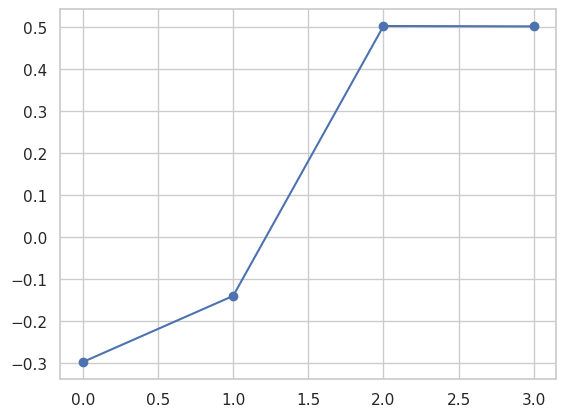

[ 0.49629113  0.7280307  -0.43961883 -0.43391368]


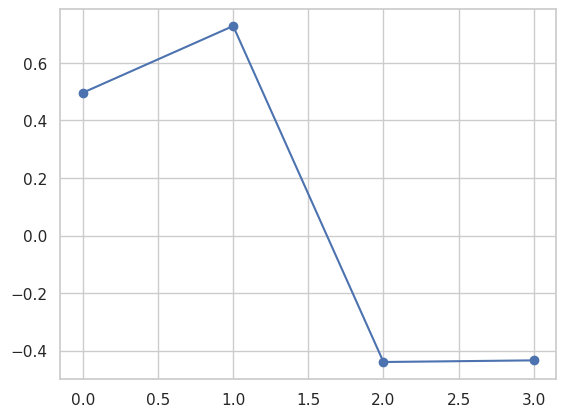

[-0.14377971 -0.17597453  0.33460698  0.2828005 ]


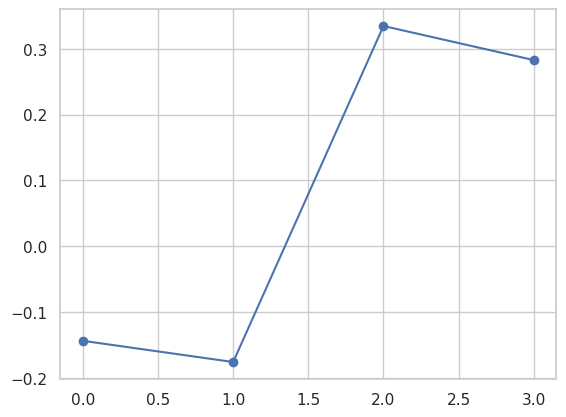

[-0.15571412 -0.07086796  0.6977241  -0.64962965]


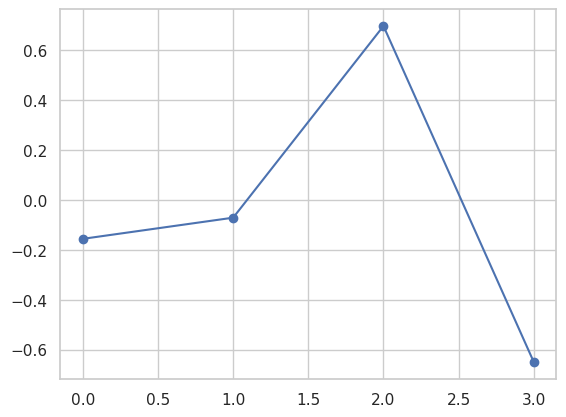

[-0.12658036  0.3891235  -0.348434   -0.34781235]


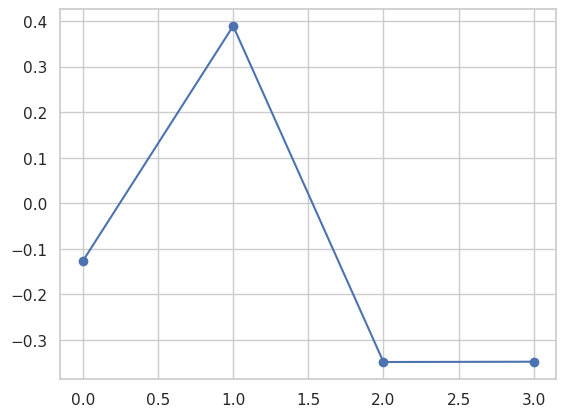

[-0.33301342 -0.32050392 -0.32030436 -0.7220343 ]


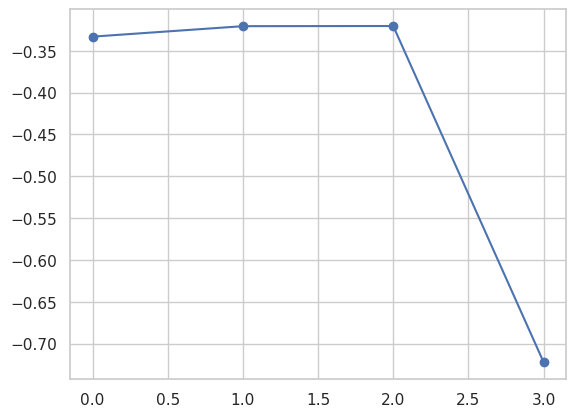

[ 0.39286724 -0.24639554  0.5505253   0.5505684 ]


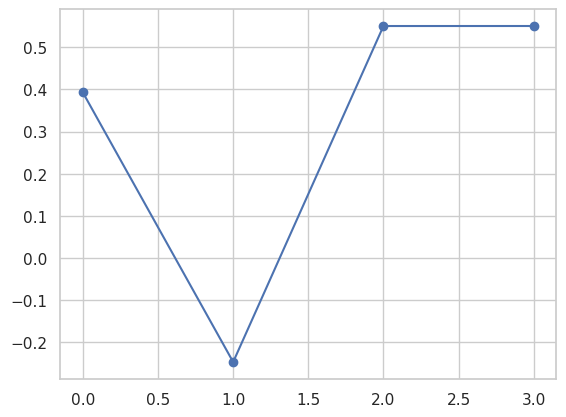

[ 0.08996971  0.4352948  -0.55213565 -0.28611347]


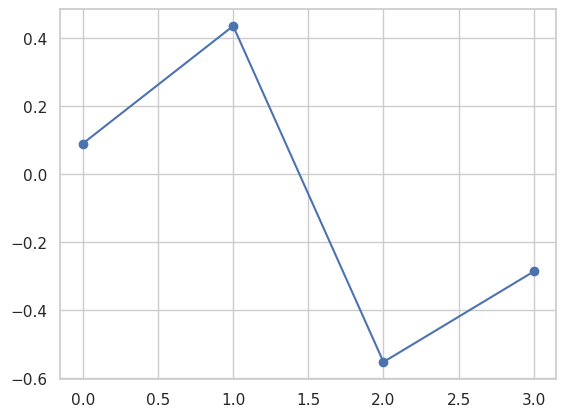

[0.337226   0.48022172 0.48026526 0.5514218 ]


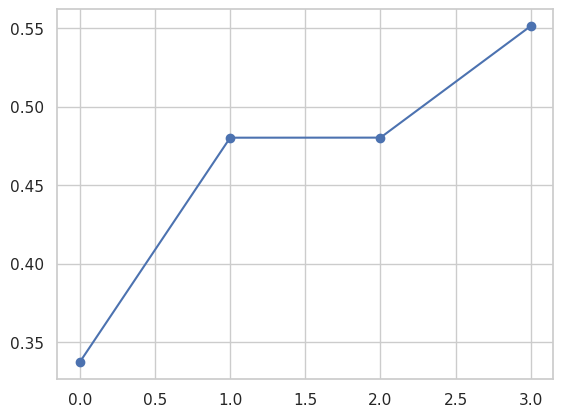

In [28]:
for w in weights[fc_weights[0]<0,:,:]:
    
    w = w.cpu().numpy().squeeze()
    print(w)
    plt.plot(np.arange(0,4),w,'o-')
    plt.show()

In [29]:
# weights_list = []


In [30]:
m = nn.Conv1d(1, 1, 3, stride=2,bias=False)


In [31]:
input = torch.tensor([1,2,3],dtype=torch.float32).reshape(1,3)

In [32]:
m.weight.data

tensor([[[0.1157, 0.0257, 0.2049]]])

In [33]:
output = m(input)

In [34]:
output

tensor([[0.7819]], grad_fn=<SqueezeBackward1>)

In [35]:
m.weight.data @ input.T

tensor([[[0.7819]]])

In [36]:
a = np.array((0.4437, -0.3275, -0.3687))
b = np.array((1,2,3))